# NB 5 | Modeling & Prediction
---
## Project:
Amazon Reviews Analysis (DSC 400)

## Dataset:
Original: SAHITYA SAHU Amazon Large Dataset (~123GB) Sampled & Cleaned: Amazon_Master_Cleaned.csv (129794, 27)

## NB Objective: 
Build predictive models to determine whether Amazon review features (features: sentiment, length, votes, verified status) can accurately predict customer star ratings.

**Tasks:**
1. Machine Learning with PySpark and MLlib
2. Deep Learning with TensorFlow and Keras
3. Natural Language Processing with NLTK and Transformers

## Setup and load
---

In [45]:
#Core
import pandas as pd
import numpy as np

#Visuals
import matplotlib.pyplot as plt
import seaborn as sns

# Ml tools / deep learning and spark
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizerFast
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

#NLP
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import os
import torch
import transformers
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset


nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lynnm\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lynnm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lynnm\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
#Load Cleaned Dataset
df_master = pd.read_csv("Amazon_FE_Dataset.csv")

print("Shape:", df_master.shape)

df_master.head()

Shape: (129794, 27)


,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,...,sentiment_polarity,sentiment_subjectivity,has_image,review_year,review_month,review_dayofweek,reviews_per_reviewer,reviews_per_product,avg_rating_product,avg_rating_reviewer
0,4,True,2017-05-09,A2VY416R3G7WD9,B0012XPRO8,Becky Ann Hathaway,i really liked this product. never really bou...,super soft,1494288000,0.0,...,0.250000,0.500000,0,2017,5,1,1,5,4.0,4.0
1,4,True,2016-06-25,A3CHVIU4GFE180,B00J9MJDFS,Anais,Have not used this item but a couple of times....,Nice product to have as it does several things...,1466812800,2.0,...,0.300000,0.500000,0,2016,6,5,1,1,4.0,4.0
2,4,True,2014-10-10,AT5L0D757JA4W,B0054EU4Z8,Luxdelux,Great cap but it doesn't really stay on my hea...,Four Stars,1412899200,0.0,...,0.400000,0.450000,0,2014,10,4,1,5,2.6,4.0
3,5,True,2013-03-03,A30X02Q6TP9G3N,B003CU26SY,sag412,I read this would help with my thinning edges....,Great!,1362268800,0.0,...,-0.150000,0.708333,0,2013,3,6,1,4,4.0,5.0
4,5,True,2017-03-01,A2V16V9O1JR53A,B01GOY8LBA,N P Hoca,My dad needed this bucket. He is 94 and in a...,"But he LOVED THIS, and told everyone how great...",1488326400,5.0,...,0.417593,0.620370,0,2017,3,2,1,1,5.0,5.0


## Data Preparation | FE (if needed)
---
Target Distribution:
|Rating Group | Count |
|-------------|-------|
|Positive (2):| 104,215  |
|Negative (0): | 16,872  |
|Neutral (1): | 8,707|

Baseline Modeling:

Will use...
- review_length
- sentiment_polarity
- vote
- verified
- rating_group (target)

In [3]:
#Missing Values Summary
missing = df_master.isnull().sum().sort_values(ascending=False)

print("Missing Values Per Column:")
missing[missing > 0]

Missing Values Per Column:


image           127382
style            81282
summary             35
reviewerName        23
reviewText           3
dtype: int64

In [4]:
#Create Rating Group Target (neg, neutral, pos)
def rating_group(rating):
    if rating <= 2:
        return 0 
    elif rating == 3:
        return 1 
    else:
        return 2

df_master["rating_group"] = df_master["overall"].apply(rating_group)

df_master["rating_group"].value_counts()

rating_group
2    104215
0     16872
1      8707
Name: count, dtype: int64

## Baseline Machine Learning (wt Spark MLlib)
---
1. Logistic Regression Baseline Results
   - Features used: review_length, sentiment_polarity, vote, verified
   - Balanced class weights (for class imbalance)
   - Target: rating_group
   - Accuracy: 61%
   - Macro Avg F1: 0.45 (confirms imbalance hurts minority classes)

In [5]:
#Convert `verified` to numeric
df_master["verified"] = df_master["verified"].astype(int)

In [6]:
#Feature List
features = ["review_length", "sentiment_polarity", "vote", "verified"]

X = df_master[features]
y = df_master["rating_group"]

In [7]:
#Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y 
)

In [8]:
#Scale Features
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
#Train Logistic Regression
log_model = LogisticRegression(
    multi_class='multinomial',
    max_iter=1000,
    class_weight='balanced'
)

log_model.fit(X_train_scaled, y_train)

C:\Users\lynnm\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(class_weight='balanced', max_iter=1000,
                   multi_class='multinomial')

In [10]:
#Evaluate
y_pred = log_model.predict(X_test_scaled)

print("Classification Report:\n")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))

Classification Report:

              precision    recall  f1-score   support

           0       0.34      0.67      0.45      3375
           1       0.10      0.32      0.16      1741
           2       0.94      0.62      0.75     20843

    accuracy                           0.61     25959
   macro avg       0.46      0.54      0.45     25959
weighted avg       0.80      0.61      0.67     25959


Confusion Matrix:

[[ 2273   694   408]
 [  694   559   488]
 [ 3655  4178 13010]]


### Baseline Improvements
---
1. Class Imbalance: SMOTE or Random Oversampling
2. Feature Engineering:
   - New features in review & user behavior and temporal trends

Models:
- Improved Logistic Regression (Balanced class weights, SMOTE Oversampling)
  - Macro F1 Score: 0.98 (compared to baseline: 0.45, significant improvement)
  - Accuracy: 99%
- Random Forest
  - Class 2 (high ratings): Dominates the dataset
  - NEED TO: check potential data leakage or highly correlated features

Feature Importance:
- Discovery
  - The model is mostly memorizing reviewer and product avg.(s) rather than patterns from data
  - Data leakage: inflates performance

In [11]:
#Improved Machine Learning
#(With extra FE & SMOTE)

# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE


#Feature Engineering

df_ml = df_master.copy()

#Reviewer/product features
df_ml['reviews_per_reviewer'] = df_ml.groupby('reviewerID')['reviewText'].transform('count')
df_ml['avg_rating_reviewer'] = df_ml.groupby('reviewerID')['overall'].transform('mean')
df_ml['reviews_per_product'] = df_ml.groupby('asin')['reviewText'].transform('count')
df_ml['avg_rating_product'] = df_ml.groupby('asin')['overall'].transform('mean')

#Temporal features
df_ml['review_year'] = pd.to_datetime(df_ml['reviewTime']).dt.year
df_ml['review_month'] = pd.to_datetime(df_ml['reviewTime']).dt.month
df_ml['review_dayofweek'] = pd.to_datetime(df_ml['reviewTime']).dt.dayofweek

#Target
y = df_ml['rating_group']  # 0,1,2 as before

#Features to use
feature_cols = [
    'review_length', 'sentiment_polarity', 'vote', 'verified',
    'word_count', 'sentence_count', 'avg_word_length', 'summary_length',
    'sentiment_subjectivity', 'has_image',
    'reviews_per_reviewer', 'avg_rating_reviewer',
    'reviews_per_product', 'avg_rating_product',
    'review_year', 'review_month', 'review_dayofweek'
]

X = df_ml[feature_cols]

#Train/Test Split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

#Class Imbalance

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

#Scale Features

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

#Train Improved Logistic Regression

clf = LogisticRegression(
    class_weight='balanced', 
    max_iter=1000,
    multi_class='multinomial',
    random_state=42
)
clf.fit(X_train_scaled, y_train_res)

#Evaluate Model
y_pred = clf.predict(X_test_scaled)

print("Classification Report Improved Logistic Regression:\n")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))

C:\Users\lynnm\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Classification Report Improved Logistic Regression:

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3375
           1       0.93      0.97      0.95      1741
           2       1.00      0.99      1.00     20843

    accuracy                           0.99     25959
   macro avg       0.97      0.99      0.98     25959
weighted avg       0.99      0.99      0.99     25959

Confusion Matrix:

[[ 3351    23     1]
 [   10  1690    41]
 [    4   103 20736]]


Classification Report (RF):
               precision    recall  f1-score   support

           0       1.00      0.99      1.00      3375
           1       0.96      0.99      0.97      1741
           2       1.00      1.00      1.00     20843

    accuracy                           1.00     25959
   macro avg       0.99      0.99      0.99     25959
weighted avg       1.00      1.00      1.00     25959



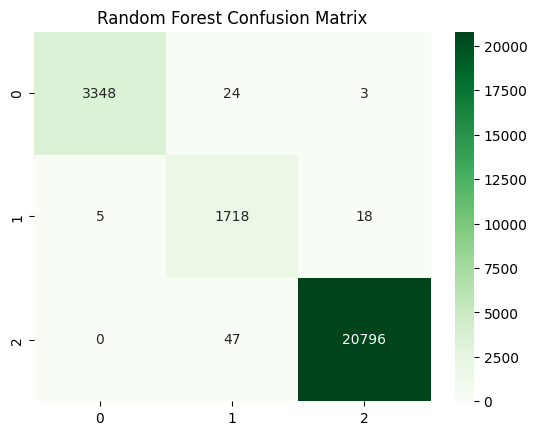

In [12]:
#RandomForest
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    class_weight='balanced',
    random_state=42
)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

print("Classification Report (RF):\n", classification_report(y_test, y_pred_rf))
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Greens")
plt.title("Random Forest Confusion Matrix")
plt.show()

In [13]:
#Check feature importance
importances = pd.Series(rf_model.feature_importances_, index=feature_cols).sort_values(ascending=False)
print(importances)

avg_rating_reviewer       0.659683
avg_rating_product        0.177290
sentiment_polarity        0.050580
summary_length            0.049338
reviews_per_product       0.017835
reviews_per_reviewer      0.010468
sentiment_subjectivity    0.008590
word_count                0.007574
review_length             0.007144
avg_word_length           0.003814
sentence_count            0.002803
review_year               0.001513
vote                      0.001375
review_month              0.000950
review_dayofweek          0.000716
verified                  0.000230
has_image                 0.000095
dtype: float64


### Address leaky features
---
Models:
Clean Random Forest
- Accuracy: 77%
- Macro F1: .58
- Insight: Middle rating is hardest to classify

In [14]:
#Drop leaky features
leaky_features = ["avg_rating_reviewer", "avg_rating_product", "vote"]

In [15]:
#Keep useful features
safe_features = [
    "sentiment_polarity",
    "sentiment_subjectivity",
    "review_length",
    "summary_length",
    "word_count",
    "sentence_count",
    "avg_word_length",
    "has_image",
    "verified",
    "review_year",
    "review_month",
    "review_dayofweek",
    "style" 
]

In [16]:
#Feature processing
X = df_master[safe_features]
y = df_master["rating_group"]

#Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [17]:
#Preprocessing prep
numeric_features = ["review_length", "summary_length", "word_count", "sentence_count", "avg_word_length", "sentiment_polarity", "sentiment_subjectivity"]
categorical_features = ["has_image", "verified", "review_year", "review_month", "review_dayofweek"]
preprocessor = ColumnTransformer(transformers=[
    ("num", StandardScaler(), numeric_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
])

In [18]:
#Pipeline
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    n_jobs=-1,
    class_weight="balanced",
    random_state=42
))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.48      0.71      0.57      3375
           1       0.24      0.40      0.30      1741
           2       0.94      0.81      0.87     20843

    accuracy                           0.77     25959
   macro avg       0.55      0.64      0.58     25959
weighted avg       0.83      0.77      0.79     25959



In [19]:
#Feature Importance
importances = pipeline.named_steps["classifier"].feature_importances_
features_processed = numeric_features + list(pipeline.named_steps["preprocessor"].named_transformers_["cat"].get_feature_names_out())
importance_df = pd.DataFrame({"feature": features_processed, "importance": importances}).sort_values(by="importance", ascending=False)

#Preview
print(importance_df.head(10))

                   feature  importance
1           summary_length    0.279908
5       sentiment_polarity    0.245283
6   sentiment_subjectivity    0.081364
0            review_length    0.073626
2               word_count    0.072772
4          avg_word_length    0.063632
3           sentence_count    0.036114
42      review_dayofweek_0    0.006245
27        review_year_2016    0.006157
44      review_dayofweek_2    0.006086


### Try 2-Step Strategy
---
Before: Accuracy 0.77

After: Accuracy 0.87

Class: (Medium)
- 0.30 to 0.50 F1
- Verify: that the single 3-class model was having problems because class 1 overlaps both 0 and 2

Insights:
- By breaking into 2 (1- separating high v not high and 2- low v medium)
- Balanced class handled
- Stronger macro performance

In [20]:
#Binary Target
df_master["is_high"] = (df_master["rating_group"] == 2).astype(int)

In [21]:
#Update
safe_features = [
    "sentiment_polarity",
    "sentiment_subjectivity",
    "review_length",
    "summary_length",
    "word_count",
    "sentence_count",
    "avg_word_length",
    "has_image",
    "verified",
    "review_year",
    "review_month",
    "review_dayofweek"
]

In [22]:
#Train Model (high v not high)
X = df_master[safe_features] 
y_stage1 = df_master["is_high"]

X_train1, X_test1, y_train1, y_test1 = train_test_split(
    X, y_stage1, stratify=y_stage1, test_size=0.2, random_state=42
)

rf_stage1 = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    class_weight="balanced",
    n_jobs=-1,
    random_state=42
)

rf_stage1.fit(X_train1, y_train1)

print("Stage 1 Report (High vs Not High)")
print(classification_report(y_test1, rf_stage1.predict(X_test1)))

Stage 1 Report (High vs Not High)
              precision    recall  f1-score   support

           0       0.62      0.59      0.61      5116
           1       0.90      0.91      0.91     20843

    accuracy                           0.85     25959
   macro avg       0.76      0.75      0.76     25959
weighted avg       0.85      0.85      0.85     25959



In [23]:
#Train (Low v medium)
df_stage2 = df_master[df_master["rating_group"] != 2].copy()

X2 = df_stage2[safe_features]
y2 = df_stage2["rating_group"]

X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X2, y2, stratify=y2, test_size=0.2, random_state=42
)

rf_stage2 = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    class_weight="balanced",
    n_jobs=-1,
    random_state=42
)

rf_stage2.fit(X_train2, y_train2)

print("Stage 2 Report (Low vs Medium)")
print(classification_report(y_test2, rf_stage2.predict(X_test2)))

Stage 2 Report (Low vs Medium)
              precision    recall  f1-score   support

           0       0.78      0.87      0.82      3375
           1       0.68      0.51      0.58      1741

    accuracy                           0.75      5116
   macro avg       0.73      0.69      0.70      5116
weighted avg       0.74      0.75      0.74      5116



In [24]:
#Combine the Predictions
def two_stage_predict(X_input):
    
#Feature order
    X_input = X_input[safe_features]
    
#Stage 1 predictions
    stage1_pred = rf_stage1.predict(X_input)
    
#Initialize final predictions
    final_pred = np.zeros(len(stage1_pred))
    
#If predicted high(2)
    final_pred[stage1_pred == 1] = 2
    
#For non-high (2)
    non_high_idx = np.where(stage1_pred == 0)[0]
    
    if len(non_high_idx) > 0:
        stage2_preds = rf_stage2.predict(X_input.iloc[non_high_idx])
        final_pred[non_high_idx] = stage2_preds
    
    return final_pred

In [25]:
#Final Predictions
y_pred_final = two_stage_predict(X_test)

print("Final Combined Model Report")
print(classification_report(y_test, y_pred_final))

Final Combined Model Report
              precision    recall  f1-score   support

           0       0.55      0.82      0.66      3375
           1       0.58      0.44      0.50      1741
           2       0.98      0.92      0.95     20843

    accuracy                           0.87     25959
   macro avg       0.70      0.73      0.70     25959
weighted avg       0.89      0.87      0.88     25959



### Breakdown of Models and Troubleshooting
---
- Model 1 — Baseline Logistic Regression
  - Features: basic numeric + sentiment
  - Accuracy: 61%
  - Macro F1: 0.45
  
Insight: Severe class imbalance 

- Model 2 — Feature-Enriched Model (Leakage Identified)
  - Performance: ~99%
  - Analysis: model memorizes reviewer/product averages
  
Conclusion: Invalid for production 

- Model 3 — Clean Random Forest
  - Accuracy: 77%
  - Macro F1: 0.58
  
Insight: Medium class is difficult due to overlap 

- Model 4 — Hierarchical Two-Stage Model (Final Spark Model)
  - Stage 1: 
    - High vs Not High 
  - Stage 2: 
    - Low vs Medium 
  - Final Performance: 
    - Accuracy: 0.87 
    - Macro F1: 0.70

NOTE: Due to limitations on Windows, certain PySpark MLlib operations are encountering connectivity and worker errors. Future plans could be to migrate to Linux.

## Deep Learning (wt TensorFlow/Keras)
---
**Goal:**  
Train a neural network using numeric and categorical features to predict `rating_group` (0: low, 1: medium, 2: high).

**Architecture:**
- Input layer: 12 numeric/categorical features

**Training:**
- Epoch: 10
- Batch size: 128
- Validation Split: 20%

**Output/Performance:**
- Accuracy: 0.825
- Macro F1: 0.45 (medium class difficulty)
- Weighted F1-score: 0.78

**Insights:**
- High Rating Class (2):
  - Performs well
  - Precision 0.85, recall 0.97
- Medium Rating Class (1):
  - Poorly predicted
  - F1-Score of 0.00
- Low Rating Class (0):
  - Moderate
  - F1-score 0.44
- While the accuracy is high, the macro-average F1. (minority classes could use further improvement)

Improvements:
- Potential oversampling or class weighting to improve predictions for the medium rating class

In [26]:
#Features & target
dl_features = [
    "sentiment_polarity",
    "sentiment_subjectivity",
    "review_length",
    "summary_length",
    "word_count",
    "sentence_count",
    "avg_word_length",
    "has_image",
    "verified",
    "review_year",
    "review_month",
    "review_dayofweek"
]

X_dl = df_master[dl_features]
y_dl = df_master["rating_group"]

#Split data
X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(
    X_dl, y_dl, stratify=y_dl, test_size=0.2, random_state=42
)

#Preprocessing
numeric_features = [
    "sentiment_polarity", "sentiment_subjectivity", "review_length",
    "summary_length", "word_count", "sentence_count", "avg_word_length"
]
categorical_features = ["has_image", "verified", "review_year", "review_month", "review_dayofweek"]

preprocessor = ColumnTransformer(transformers=[
    ("num", StandardScaler(), numeric_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
])

#Transform features
X_train_scaled = preprocessor.fit_transform(X_train_dl)
X_test_scaled = preprocessor.transform(X_test_dl)

#One-hot encode target
y_train_cat = to_categorical(y_train_dl)
y_test_cat = to_categorical(y_test_dl)

In [27]:
#Build Neural Network Model

model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(3, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

C:\Users\lynnm\miniconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           6,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,851 (58.01 KB)

 Trainable params: 14,851 (58.01 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
#Train & Evaluate the model
#Train
history = model.fit(
    X_train_scaled, y_train_cat,
    validation_split=0.2,
    epochs=10,
    batch_size=128,
    verbose=1
)

#Evaluate
test_loss, test_acc = model.evaluate(X_test_scaled, y_test_cat)
print(f"Deep Learning Test Accuracy: {test_acc:.4f}")

Epoch 1/10
649/649 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - accuracy: 0.8165 - loss: 0.5263 - val_accuracy: 0.8206 - val_loss: 0.5070
Epoch 2/10
649/649 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.8243 - loss: 0.5040 - val_accuracy: 0.8227 - val_loss: 0.5056
Epoch 3/10
649/649 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.8255 - loss: 0.5004 - val_accuracy: 0.8232 - val_loss: 0.5050
Epoch 4/10
649/649 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.8266 - loss: 0.4978 - val_accuracy: 0.8223 - val_loss: 0.5057
Epoch 5/10
649/649 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.8265 - loss: 0.4956 - val_accuracy: 0.8230 - val_loss: 0.5052
Epoch 6/10
649/649 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.8266 - loss: 0.4950 - val_accuracy: 0.8233 - val_loss: 0.5035
Epoch 7/10
649/649 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - accuracy: 0.8281 - loss: 0.4932 - val_accuracy: 0.8225 - val_loss: 0.5048
Epoch 8/10
649/649 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - accuracy: 0.8272 - loss: 0.4930 - 

812/812 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step
Classification Report:

              precision    recall  f1-score   support

           0       0.59      0.33      0.43      3375
           1       0.00      0.00      0.00      1741
           2       0.84      0.97      0.90     20843

    accuracy                           0.82     25959
   macro avg       0.48      0.44      0.44     25959
weighted avg       0.75      0.82      0.78     25959



C:\Users\lynnm\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lynnm\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lynnm\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


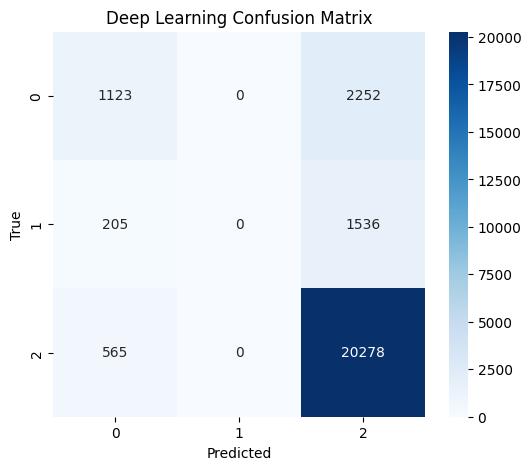

In [29]:
#Predictions & Classification Report
y_pred_dl = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred_dl, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes))

#Confusion Matrix
cm_dl = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(6,5))
sns.heatmap(cm_dl, annot=True, fmt="d", cmap="Blues")
plt.title("Deep Learning Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## Natural Language Processing with NLTL and Transformers
---
1. Preprocessing with NLTK
   - Prepared for tokenization
3. Fine-tuning a Transformer
   - Used DistilBERT for sequence classification (3 classes- Negative, Neutral, Positive)

**Training Results:**
|Epoch |  Training Loss | Validation Loss| Accuracy|
|------|----------------|----------------|---------|
|1 | 0.434 | 0.507| 0.814|
|2| 0.508 | 0.502 | 0.826 |

**Evaluation Metrics:**
- Loss: 0.502
- Accuracy: 0.826

These metrics show that the model successfully learned to classify reviews into sentiment categories. The fine-tuning of a pre-trained Transformer allowed for high performance even with a relatively smaller dataset (due to model training time)

In [30]:
#NLTK
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Preprocessing function
def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text)  
    tokens = nltk.word_tokenize(text)  
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in stop_words] 
    return " ".join(tokens)

# Apply preprocessing to `reviewText`
df_master['review_clean'] = df_master['reviewText'].apply(preprocess_text)

# Preview
df_master[['reviewText', 'review_clean']].head()

,reviewText,review_clean
0,i really liked this product. never really bou...,really liked product never really bought lady ...
1,Have not used this item but a couple of times....,used item couple time nice product several thi...
2,Great cap but it doesn't really stay on my hea...,great cap doesnt really stay head whole night
3,I read this would help with my thinning edges....,read would help thinning edge work pretty well...
4,My dad needed this bucket. He is 94 and in a...,dad needed bucket assisted living therefore el...


In [55]:
#Train/test split
X_text = df_master['review_clean'].tolist()
y_text = df_master['rating_group'].tolist()

X_train_text, X_test_text, y_train_text, y_test_text = train_test_split(
    X_text, y_text, test_size=0.2, stratify=y_text, random_state=42
)

# Convert to Hugging Face
train_dataset = Dataset.from_dict({'text': X_train_text, 'label': y_train_text})
test_dataset  = Dataset.from_dict({'text': X_test_text, 'label': y_test_text})

In [62]:
# Load tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# Tokenize datasets
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True, max_length=128)

train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset  = test_dataset.map(tokenize, batched=True)

# Set format
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

# Reduce dataset size for faster training
train_tiny = train_dataset.shuffle(seed=42).select(range(2000))
test_tiny = test_dataset.shuffle(seed=42).select(range(500))

Map:   0%|          | 0/103835 [00:00<?, ? examples/s]

Map:   0%|          | 0/25959 [00:00<?, ? examples/s]

In [63]:
# Load model (3 classes- Negative, Neutral, Positive)
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=3 
)

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_transform.weight  | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
classifier.bias         | MISSING    | 
classifier.weight       | MISSING    | 
pre_classifier.bias     | MISSING    | 
pre_classifier.weight   | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


In [64]:
# Define metrics
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    return {
        "accuracy": (preds == labels).mean()
    }

In [69]:
os.environ["TENSORBOARD_LOGGING_DIR"] = "./logs"

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=2,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_steps=10,
    eval_strategy="epoch",
    save_strategy="no"
)

In [70]:
#Create Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tiny,
    eval_dataset=test_tiny,
    compute_metrics=compute_metrics
)

In [71]:
#Train Model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.433500,0.507194,0.814000
2,0.507891,0.502257,0.826000


TrainOutput(global_step=126, training_loss=0.4953753815756904, metrics={'train_runtime': 1354.193, 'train_samples_per_second': 2.954, 'train_steps_per_second': 0.093, 'total_flos': 132469761024000.0, 'train_loss': 0.4953753815756904, 'epoch': 2.0})

In [72]:
# Evaluate
trainer.evaluate()

{'eval_loss': 0.5022567510604858,
 'eval_accuracy': 0.826,
 'eval_runtime': 95.2761,
 'eval_samples_per_second': 5.248,
 'eval_steps_per_second': 0.084,
 'epoch': 2.0}